In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq
from tqdm import tqdm
from numpy.polynomial import Polynomial
import warnings
import wrds
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import brentq

In [2]:
def blackscholes_mc(S=100, vol=0.2, r=0, q=0, ts=np.linspace(0, 1, 13), npaths=10):
    nsteps = len(ts) - 1
    ts = np.asfarray(ts)[:, np.newaxis]
    W = np.cumsum(np.vstack((np.zeros((1, npaths), dtype=float),
                             np.random.randn(nsteps, npaths) * np.sqrt(np.diff(ts, axis=0)))),
                  axis=0)
    paths = np.exp(-0.5*vol**2*ts + vol*W)*S*np.exp((r-q)*ts)
    return paths


def blackscholes_price(K, T, S, vol, r=0, q=0, callput='call'):
    F = S*np.exp((r-q)*T)
    v = np.sqrt(vol**2*T)
    d1 = np.log(F/K)/v + 0.5*v
    d2 = d1 - v
    try:
        opttype = {'call':1, 'put':-1}[callput.lower()]
    except:
        raise ValueError('The value of callput must be either "call" or "put".')
    price = opttype*(F*norm.cdf(opttype*d1)-K*norm.cdf(opttype*d2))*np.exp(-r*T)
    return price

In [3]:
CONFIG = {
    'X0': 100,
    'T': 1.0,
    'r': 0.0,
    'q': 0.0,
    
    'sigma_low': 0.1,
    'sigma_high': 0.2,
    'sigma_hat': 0.15,
    
    'K1': 90,
    'K2': 110,
    
    'n_steps_1': 12,
    'n_paths_1': 5000,

    'n_steps_2': 360,
    'n_paths_2': 50000,
    
    'poly_deg': 5,
}

In [4]:
def Sigma(gamma):
    return np.where(gamma >= 0, CONFIG['sigma_high'], CONFIG['sigma_low'])


def payoff(x):
    K1, K2 = CONFIG['K1'], CONFIG['K2']
    return 100 / (K2 - K1) * (np.maximum(x - K1, 0) - np.maximum(x - K2, 0))


def payoff_deriv(x):
    K1, K2 = CONFIG['K1'], CONFIG['K2']
    return 100 / (K2 - K1) * ((x > K1).astype(float) - (x > K2).astype(float))


In [5]:
def make_get_Gamma(Gamma_polys, n_steps, T, sigma_hat):
    dt = T / n_steps
    
    def get_Gamma(t, x):
        idx = int(t * n_steps / T)
        idx = min(idx, n_steps - 1)
        poly = Gamma_polys[idx]
        return poly(x) / (dt * sigma_hat * x)
    
    return get_Gamma

In [6]:
np.random.seed(42)

X0 = CONFIG['X0']
T = CONFIG['T']
sigma_hat = CONFIG['sigma_hat']
n_steps_1 = CONFIG['n_steps_1']
n_paths_1 = CONFIG['n_paths_1']
deg = CONFIG['poly_deg']

ts_1 = np.linspace(0, T, n_steps_1 + 1)
dt_1 = np.diff(ts_1)

dW_1 = np.random.randn(n_steps_1, n_paths_1) * np.sqrt(dt_1[:, np.newaxis])
W_1 = np.vstack([np.zeros((1, n_paths_1)), np.cumsum(dW_1, axis=0)])

paths_1 = X0 * np.exp(-0.5 * sigma_hat**2 * ts_1[:, np.newaxis] + sigma_hat * W_1)

Y = payoff(paths_1[-1])
Z = payoff_deriv(paths_1[-1])

Gamma_polys = [None] * n_steps_1

for i in range(n_steps_1, 0, -1):
    X_prev = paths_1[i-1]
    dt = dt_1[i-1]
    dW = dW_1[i-1]
    
    poly_Gamma = Polynomial.fit(X_prev, Z * dW, deg)
    Gamma = poly_Gamma(X_prev) / (dt * sigma_hat * X_prev)
    Gamma_polys[i-1] = poly_Gamma

    poly_Z = Polynomial.fit(X_prev, Y * dW, deg)
    Z = poly_Z(X_prev) / (dt * sigma_hat * X_prev)
    
    poly_Y = Polynomial.fit(X_prev, Y, deg)
    E_Y = poly_Y(X_prev)
    Y = E_Y + 0.5 * Gamma * X_prev**2 * (Sigma(Gamma)**2 - sigma_hat**2) * dt

step1_price = np.mean(Y)
print(f"Step 1 price: {step1_price:.4f}")
print(f"True price: 56.0")
print(f"Error: {abs(step1_price - 56) / 56 * 100:.2f}%")

Step 1 price: 56.0051
True price: 56.0
Error: 0.01%


In [7]:
np.random.seed(123)

n_steps_2 = CONFIG['n_steps_2']
n_paths_2 = CONFIG['n_paths_2']

get_Gamma = make_get_Gamma(Gamma_polys, n_steps_1, T, sigma_hat)

dt_2 = T / n_steps_2

paths_2 = np.zeros((n_steps_2 + 1, n_paths_2))
paths_2[0] = X0

for i in range(n_steps_2):
    t = i * dt_2 
    X = paths_2[i]
    
    Gamma = get_Gamma(t, X)
    sigma = Sigma(Gamma)
    
    dW = np.random.randn(n_paths_2) * np.sqrt(dt_2)
    paths_2[i+1] = X * np.exp(-0.5 * sigma**2 * dt_2 + sigma * dW)

step2_price = np.mean(payoff(paths_2[-1]))
print(f"Step 2 price: {step2_price:.4f}")
print(f"True price: 56.0")
print(f"Error: {abs(step2_price - 56) / 56 * 100:.2f}%")

Step 2 price: 54.4959
True price: 56.0
Error: 2.69%


In [8]:
conn = wrds.Connection()

print("Connected to WRDS successfully!")
print(f"Available libraries: {conn.list_libraries()[:5]}...")

WRDS recommends setting up a .pgpass file.
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done
Connected to WRDS successfully!
Available libraries: ['aha_sample', 'ahasamp', 'audit', 'audit_audit_comp', 'audit_common']...


In [9]:
secid_query = """
    SELECT secid, ticker, cusip
    FROM optionm.securd
    WHERE ticker = 'SPY'
"""
spy_info = conn.raw_sql(secid_query)
print("SPY info:")
print(spy_info)

SPY info:
      secid ticker     cusip
0    7571.0    SPY  81750M10
1  100155.0    SPY  32299W10
2  109820.0    SPY  78462F10
3  115101.0    SPY  93099W10


In [10]:
query = """
    SELECT 
        date, exdate, cp_flag, strike_price/1000 as strike,
        best_bid, best_offer, impl_volatility, delta, gamma
    FROM optionm.opprcd2025
    WHERE secid = 109820
        AND date IN ('2025-01-31', '2025-02-28', '2025-03-31', 
                     '2025-04-30', '2025-05-30', '2025-06-30')
        AND impl_volatility IS NOT NULL
        AND best_bid > 0
    ORDER BY date, cp_flag, strike_price
"""
options_df = conn.raw_sql(query)

print(f"Rows: {len(options_df)}")
print(f"Dates: {sorted(options_df['date'].unique())}")
print(f"Strike range: {options_df['strike'].min()} ~ {options_df['strike'].max()}")

Rows: 49154
Dates: ['2025-01-31', '2025-02-28', '2025-03-31', '2025-04-30', '2025-05-30', '2025-06-30']
Strike range: 150.0 ~ 915.0


In [11]:
spot_query = """
    SELECT date, close
    FROM optionm.secprd2025
    WHERE secid = 109820
        AND date IN ('2025-01-31', '2025-02-28', '2025-03-31', 
                     '2025-04-30', '2025-05-30', '2025-06-30')
    ORDER BY date
"""
spot_df = conn.raw_sql(spot_query)

In [12]:
spot_dict = dict(zip(spot_df['date'].astype(str), spot_df['close']))
print("Spot prices:", spot_dict)

filtered_options = []

for date_str, spot in spot_dict.items():
    df_date = options_df[options_df['date'].astype(str) == date_str].copy()
    
    df_date['days_to_exp'] = (pd.to_datetime(df_date['exdate']) - pd.to_datetime(df_date['date'])).dt.days
    df_date = df_date[(df_date['days_to_exp'] >= 20) & (df_date['days_to_exp'] <= 40)]
    
    strike_low = spot * 0.8
    strike_high = spot * 1.2
    df_date = df_date[(df_date['strike'] >= strike_low) & (df_date['strike'] <= strike_high)]
    
    df_date['spot'] = spot
    df_date['moneyness'] = df_date['strike'] / spot
    
    filtered_options.append(df_date)

options_filtered = pd.concat(filtered_options, ignore_index=True)

print(f"\nFiltered rows: {len(options_filtered)}")
print(f"Dates: {sorted(options_filtered['date'].unique())}")
print(options_filtered.head(10))

Spot prices: {'2025-01-31': np.float64(601.82), '2025-02-28': np.float64(594.18), '2025-03-31': np.float64(559.39), '2025-04-30': np.float64(554.54), '2025-05-30': np.float64(589.39), '2025-06-30': np.float64(617.85)}

Filtered rows: 4471
Dates: ['2025-01-31', '2025-02-28', '2025-03-31', '2025-04-30', '2025-05-30', '2025-06-30']
         date      exdate cp_flag  strike  best_bid  best_offer  \
0  2025-01-31  2025-03-07       C   485.0    119.03       119.8   
1  2025-01-31  2025-02-28       C   485.0    118.52      119.29   
2  2025-01-31  2025-02-21       C   485.0    118.25      118.75   
3  2025-01-31  2025-02-28       C   490.0    113.57      114.32   
4  2025-01-31  2025-02-21       C   490.0    113.01      113.77   
5  2025-01-31  2025-03-07       C   490.0    114.36      114.85   
6  2025-01-31  2025-02-21       C   495.0    108.04       108.8   
7  2025-01-31  2025-02-28       C   495.0    108.59      109.35   
8  2025-01-31  2025-03-07       C   495.0    109.14      109.89   

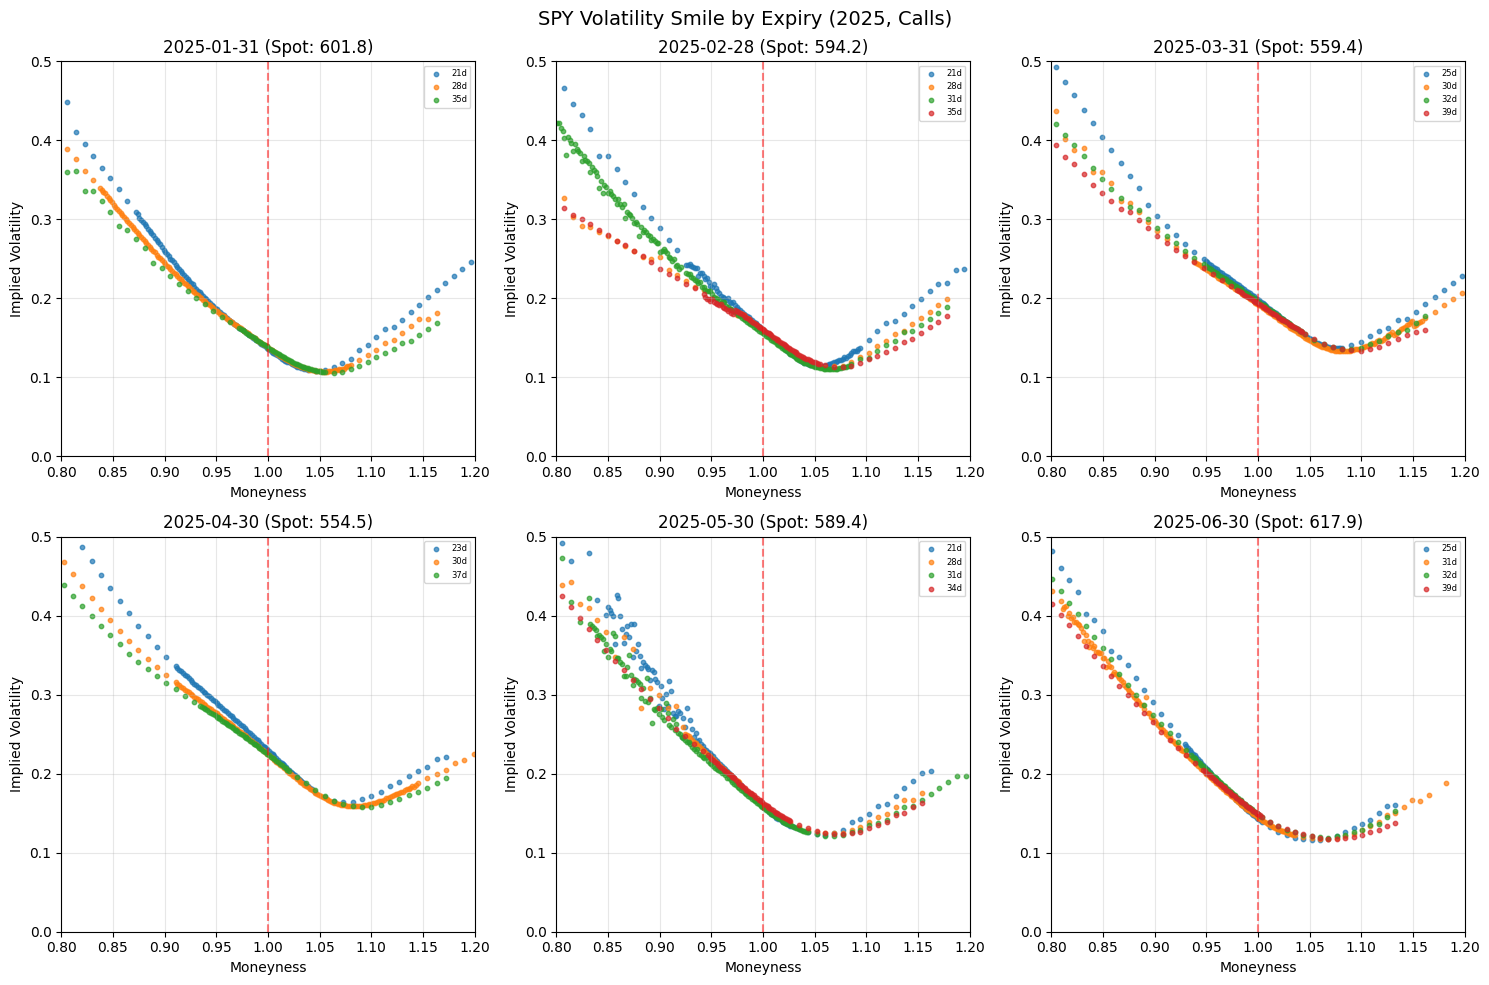

In [13]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

dates = sorted(options_filtered['date'].astype(str).unique())

for i, date_str in enumerate(dates):
    df_sample = options_filtered[
        (options_filtered['date'].astype(str) == date_str) & 
        (options_filtered['cp_flag'] == 'C')
    ]
    
    spot = df_sample['spot'].iloc[0]
    
    for exdate, group in df_sample.groupby('exdate'):
        days = group['days_to_exp'].iloc[0]
        axes[i].scatter(group['moneyness'], group['impl_volatility'], 
                       alpha=0.7, s=10, label=f'{days}d')
    
    axes[i].axvline(x=1.0, color='r', linestyle='--', alpha=0.5)
    axes[i].set_xlabel('Moneyness')
    axes[i].set_ylabel('Implied Volatility')
    axes[i].set_title(f'{date_str} (Spot: {spot:.1f})')
    axes[i].set_xlim(0.8, 1.2)
    axes[i].set_ylim(0, 0.5)
    axes[i].grid(True, alpha=0.3)
    axes[i].legend(fontsize=6, loc='upper right')

plt.suptitle('SPY Volatility Smile by Expiry (2025, Calls)', fontsize=14)
plt.tight_layout()
plt.show()

In [14]:
atm_options = options_filtered[
    (options_filtered['moneyness'] >= 0.95) & 
    (options_filtered['moneyness'] <= 1.05)
]

print("ATM IV Statistics:")
print(f"  Min: {atm_options['impl_volatility'].min():.4f}")
print(f"  Max: {atm_options['impl_volatility'].max():.4f}")
print(f"  Mean: {atm_options['impl_volatility'].mean():.4f}")

print("\nFull IV Range:")
print(f"  Min (sigma_low candidate): {options_filtered['impl_volatility'].min():.4f}")
print(f"  Max (sigma_high candidate): {options_filtered['impl_volatility'].max():.4f}")

print("\nATM IV by Date (mean):")
for date_str in sorted(atm_options['date'].astype(str).unique()):
    df_date = atm_options[atm_options['date'].astype(str) == date_str]
    print(f"  {date_str}: {df_date['impl_volatility'].mean():.4f}")

ATM IV Statistics:
  Min: 0.0656
  Max: 0.2891
  Mean: 0.1704

Full IV Range:
  Min (sigma_low candidate): 0.0656
  Max (sigma_high candidate): 0.5246

ATM IV by Date (mean):
  2025-01-31: 0.1387
  2025-02-28: 0.1532
  2025-03-31: 0.1879
  2025-04-30: 0.2245
  2025-05-30: 0.1648
  2025-06-30: 0.1571


## Parameter Calibration

Based on SPY market data (Jan-Jun 2025):

- **sigma_low = 0.07**: Minimum ATM implied volatility observed
- **sigma_high = 0.29**: Maximum ATM implied volatility observed
- **sigma_hat = 0.17**: Mean ATM IV (reference volatility for simulation)

ATM options (moneyness 0.95~1.05) used for calibration due to higher liquidity and reliability.

In [15]:
CONFIG['sigma_low'] = 0.07
CONFIG['sigma_high'] = 0.29
CONFIG['sigma_hat'] = 0.17

print("Updated CONFIG:")
print(f"  sigma_low: {CONFIG['sigma_low']}")
print(f"  sigma_high: {CONFIG['sigma_high']}")
print(f"  sigma_hat: {CONFIG['sigma_hat']}")

Updated CONFIG:
  sigma_low: 0.07
  sigma_high: 0.29
  sigma_hat: 0.17


In [16]:
test_date = '2025-01-31'
test_spot = spot_dict[test_date]

CONFIG['X0'] = test_spot
CONFIG['T'] = 30/365

print(f"Test date: {test_date}")
print(f"Spot (X0): {CONFIG['X0']:.2f}")
print(f"T: {CONFIG['T']:.4f} years ({CONFIG['T']*365:.0f} days)")

Test date: 2025-01-31
Spot (X0): 601.82
T: 0.0822 years (30 days)


In [17]:
np.random.seed(42)

X0 = CONFIG['X0']
T = CONFIG['T']
sigma_hat = CONFIG['sigma_hat']
n_steps_1 = CONFIG['n_steps_1']
n_paths_1 = CONFIG['n_paths_1']
deg = CONFIG['poly_deg']

ts_1 = np.linspace(0, T, n_steps_1 + 1)
dt_1 = np.diff(ts_1)

dW_1 = np.random.randn(n_steps_1, n_paths_1) * np.sqrt(dt_1[:, np.newaxis])
W_1 = np.vstack([np.zeros((1, n_paths_1)), np.cumsum(dW_1, axis=0)])

paths_1 = X0 * np.exp(-0.5 * sigma_hat**2 * ts_1[:, np.newaxis] + sigma_hat * W_1)

Y = payoff(paths_1[-1])
Z = payoff_deriv(paths_1[-1])

Gamma_polys = [None] * n_steps_1

for i in range(n_steps_1, 0, -1):
    X_prev = paths_1[i-1]
    dt = dt_1[i-1]
    dW = dW_1[i-1]
    
    poly_Gamma = Polynomial.fit(X_prev, Z * dW, deg)
    Gamma = poly_Gamma(X_prev) / (dt * sigma_hat * X_prev)
    Gamma_polys[i-1] = poly_Gamma

    poly_Z = Polynomial.fit(X_prev, Y * dW, deg)
    Z = poly_Z(X_prev) / (dt * sigma_hat * X_prev)
    
    poly_Y = Polynomial.fit(X_prev, Y, deg)
    E_Y = poly_Y(X_prev)
    Y = E_Y + 0.5 * Gamma * X_prev**2 * (Sigma(Gamma)**2 - sigma_hat**2) * dt

print("Gamma estimation complete")
print(f"X0: {X0:.2f}, T: {T:.4f}, sigma_hat: {sigma_hat}")

Gamma estimation complete
X0: 601.82, T: 0.0822, sigma_hat: 0.17


In [ ]:
def payoff_call_vanilla(x, K):
    return np.maximum(x - K, 0)

def payoff_call_vanilla_deriv(x, K):
    return (x > K).astype(float)

def implied_vol(price, K, T, S, r=0):
    if price <= 0:
        return np.nan
    intrinsic = max(S - K, 0)
    if price < intrinsic:
        return np.nan
    def objective(sigma):
        return blackscholes_price(K, T, S, sigma, r=r, callput='call') - price
    try:
        iv = brentq(objective, 1e-6, 3.0)
    except ValueError:
        iv = np.nan
    return iv

np.random.seed(42)

strikes_test = np.linspace(X0 * 0.85, X0 * 1.15, 15)
model_ivs_B = []

for K in tqdm(strikes_test, desc="Processing strikes"):
    ts_1 = np.linspace(0, T, n_steps_1 + 1)
    dt_1 = np.diff(ts_1)
    dW_1 = np.random.randn(n_steps_1, n_paths_1) * np.sqrt(dt_1[:, np.newaxis])
    W_1 = np.vstack([np.zeros((1, n_paths_1)), np.cumsum(dW_1, axis=0)])
    paths_1 = X0 * np.exp(-0.5 * sigma_hat**2 * ts_1[:, np.newaxis] + sigma_hat * W_1)
    
    Y = payoff_call_vanilla(paths_1[-1], K)
    Z = payoff_call_vanilla_deriv(paths_1[-1], K)
    
    Gamma_polys_K = [None] * n_steps_1
    
    for i in range(n_steps_1, 0, -1):
        X_prev = paths_1[i-1]
        dt = dt_1[i-1]
        dW = dW_1[i-1]
        
        poly_Gamma = Polynomial.fit(X_prev, Z * dW, deg)
        Gamma = poly_Gamma(X_prev) / (dt * sigma_hat * X_prev)
        Gamma_polys_K[i-1] = poly_Gamma
        
        poly_Z = Polynomial.fit(X_prev, Y * dW, deg)
        Z = poly_Z(X_prev) / (dt * sigma_hat * X_prev)
        
        poly_Y = Polynomial.fit(X_prev, Y, deg)
        E_Y = poly_Y(X_prev)
        Y = E_Y + 0.5 * Gamma * X_prev**2 * (Sigma(Gamma)**2 - sigma_hat**2) * dt
    
    get_Gamma_K = make_get_Gamma(Gamma_polys_K, n_steps_1, T, sigma_hat)
    
    dt_2 = T / n_steps_2
    paths_2 = np.zeros((n_steps_2 + 1, n_paths_2))
    paths_2[0] = X0
    
    for i in range(n_steps_2):
        t = i * dt_2
        X = paths_2[i]
        Gamma = get_Gamma_K(t, X)
        sigma = Sigma(Gamma)
        dW = np.random.randn(n_paths_2) * np.sqrt(dt_2)
        paths_2[i+1] = X * np.exp(-0.5 * sigma**2 * dt_2 + sigma * dW)
    
    X_T = paths_2[-1]
    price = np.mean(np.maximum(X_T - K, 0))
    iv = implied_vol(price, K, T, X0)
    model_ivs_B.append(iv)

model_ivs_B = np.array(model_ivs_B)
moneyness_B = strikes_test / X0

print("Method B complete")
print(f"IV range: {np.nanmin(model_ivs_B):.4f} ~ {np.nanmax(model_ivs_B):.4f}")

Processing strikes: 100%|██████████| 15/15 [00:05<00:00,  2.90it/s]

Method B complete
IV range: 0.1974 ~ 0.2817


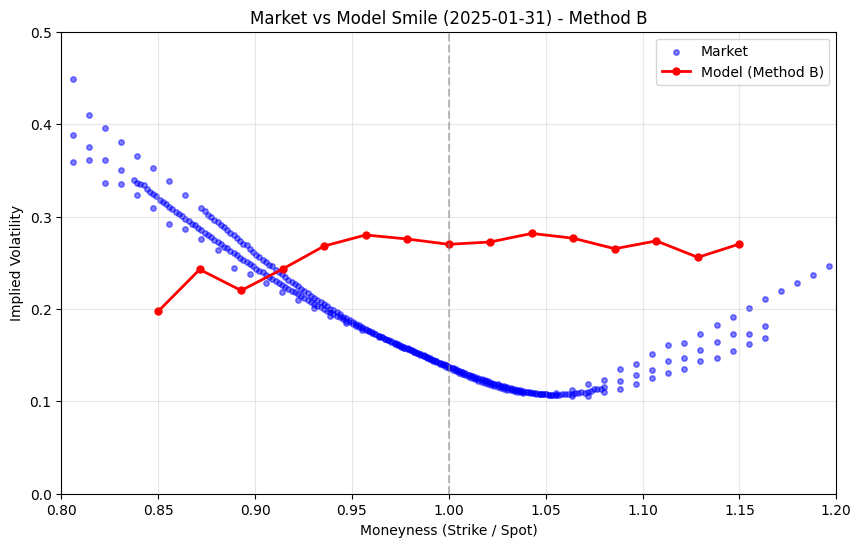

Model IV range: 0.1974 ~ 0.2817
Market IV range: 0.1058 ~ 0.4483


In [ ]:
market_data = options_filtered[
    (options_filtered['date'].astype(str) == test_date) & 
    (options_filtered['cp_flag'] == 'C')
]

plt.figure(figsize=(10, 6))

plt.scatter(market_data['moneyness'], market_data['impl_volatility'], 
           alpha=0.5, s=15, label='Market', color='blue')

plt.plot(moneyness_B, model_ivs_B, 'r-o', linewidth=2, markersize=5, label='Model (Method B)')

plt.axvline(x=1.0, color='gray', linestyle='--', alpha=0.5)
plt.xlabel('Moneyness (Strike / Spot)')
plt.ylabel('Implied Volatility')
plt.title(f'Market vs Model Smile ({test_date}) - Method B')
plt.legend()
plt.xlim(0.8, 1.2)
plt.ylim(0, 0.5)
plt.grid(True, alpha=0.3)
plt.show()

print(f"Model IV range: {np.nanmin(model_ivs_B):.4f} ~ {np.nanmax(model_ivs_B):.4f}")
print(f"Market IV range: {market_data['impl_volatility'].min():.4f} ~ {market_data['impl_volatility'].max():.4f}")

## Conclusion: Smile Verification

The Uncertain Volatility Model **fails to reproduce** the market volatility smile.

**Observations:**
- Market: Clear skew pattern (high IV for ITM, low at ATM, rising for OTM)
- Model: Nearly flat IV (~0.20-0.28) regardless of strike

**Possible reasons:**
- The model is designed for worst-case superhedging pricing, not smile calibration
- The switching mechanism (σ_low vs σ_high based on Γ sign) is too simple to capture market dynamics

**Next steps:**
- Discuss alternative smile calibration models on Friday
- Proceed to Phase 2 (X* - X analysis) with current model